# Edge AI Prototype — lightweight image classifier
Goal: train a small image classifier (recognize recyclables) and convert to TensorFlow Lite.


In [ ]:
#import libraries needed
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import os


In [14]:
#load images with Keras utility 
data_dir = "Garbage_Classification"  
image_size = (128, 128)         
batch_size = 16

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,      # 80% training, 20% validation
    subset="training",
    seed=42,
    image_size=image_size,
    batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=image_size,
    batch_size=batch_size
)

class_names = train_ds.class_names
print("Classes:", class_names)


Found 4133 files belonging to 7 classes.
Using 3307 files for training.
Found 4133 files belonging to 7 classes.
Using 826 files for validation.
Classes: ['Battery', 'Cardboard', 'Clothes', 'Glass', 'Metal', 'Paper', 'Plastic']


In [3]:
# Build a simple CNN model
num_classes = len(class_names)

model = keras.Sequential([
    layers.Rescaling(1./255, input_shape=(image_size[0], image_size[1], 3)),
    layers.Conv2D(16, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


c:\Users\Juliet Asiedu\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 126, 126, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 28800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     1,843,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,848,807 (7.05 MB)

 Trainable params: 1,848,807 (7.05 MB)

 Non-trainable params: 0 (0.00 B)

In [4]:
# Model Training
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=6
)


Epoch 1/6
207/207 ━━━━━━━━━━━━━━━━━━━━ 206s 922ms/step - accuracy: 0.4249 - loss: 1.5287 - val_accuracy: 0.4818 - val_loss: 1.4461
Epoch 2/6
207/207 ━━━━━━━━━━━━━━━━━━━━ 137s 662ms/step - accuracy: 0.5975 - loss: 1.0945 - val_accuracy: 0.5775 - val_loss: 1.1770
Epoch 3/6
207/207 ━━━━━━━━━━━━━━━━━━━━ 144s 670ms/step - accuracy: 0.7034 - loss: 0.8268 - val_accuracy: 0.5860 - val_loss: 1.1707
Epoch 4/6
207/207 ━━━━━━━━━━━━━━━━━━━━ 164s 793ms/step - accuracy: 0.7889 - loss: 0.6026 - val_accuracy: 0.6174 - val_loss: 1.2298
Epoch 5/6
207/207 ━━━━━━━━━━━━━━━━━━━━ 188s 723ms/step - accuracy: 0.8476 - loss: 0.4545 - val_accuracy: 0.6259 - val_loss: 1.3696
Epoch 6/6
207/207 ━━━━━━━━━━━━━━━━━━━━ 212s 1s/step - accuracy: 0.9023 - loss: 0.3111 - val_accuracy: 0.6404 - val_loss: 1.3485


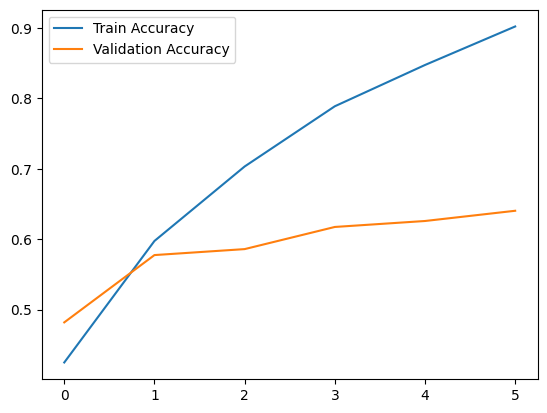

In [15]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()


In [18]:
# Save the Keras Model
model.save("recyclable_model.keras")  


In [ ]:
# Convert to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("garbage_classifier.tflite", "wb") as f:
    f.write(tflite_model)


INFO:tensorflow:Assets written to: C:\Users\JULIET~1\AppData\Local\Temp\tmpol80t5nv\assets


INFO:tensorflow:Assets written to: C:\Users\JULIET~1\AppData\Local\Temp\tmpol80t5nv\assets


Saved artifact at 'C:\Users\JULIET~1\AppData\Local\Temp\tmpol80t5nv'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 7), dtype=tf.float32, name=None)
Captures:
  1313236661072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1313236661264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1313236659920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1313236661456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1313236662224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1313236661648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1313236661840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1313236662800: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [19]:
# Quick test — run TFLite model on one image from validation set
interpreter = tf.lite.Interpreter(model_path="garbage_classifier.tflite")
interpreter.allocate_tensors()
print("TFLite model loaded successfully!")


TFLite model loaded successfully!


c:\Users\Juliet Asiedu\AppData\Local\Programs\Python\Python312\Lib\site-packages\tensorflow\lite\python\interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)
